## Demonstration of parallel MCMC

This notebook shows how to run distributed/parallel MCMC parameter inference. We use the same dataset and recover similar results to [the main demo notebook](/songbird.ipynb).

**Important Note:** We set `config[:num_threads] = 2` on this dataset for demonstration. For a dataset this small, adding additional threads is risky &mdash; as we describe in our paper, the parallel MCMC routine we use introduces boundary effects, because there is no data sharing across threads. Parallel inference is intended for very large datasets (e.g. containing hours of data). In this regime, the the boundary effects are extremely minor. However, on this small demo dataset they may not be.

In [2]:
# Import PPSeq
import PPSeq
const seq = PPSeq

# Other Imports
import PyPlot: plt
import DelimitedFiles: readdlm
import Random
import StatsBase: quantile

# Songbird metadata
num_neurons = 75
max_time = 22.2

# Randomly permute neuron labels.
# (This hides the sequences, to make things interesting.)
_p = Random.randperm(num_neurons)

# Load spikes.
spikes = seq.Spike[]
for (n, t) in eachrow(readdlm("data/songbird_spikes.txt", '\t', Float64, '\n'))
    push!(spikes, seq.Spike(_p[Int(n)], t))
end

## Plot a spike raster

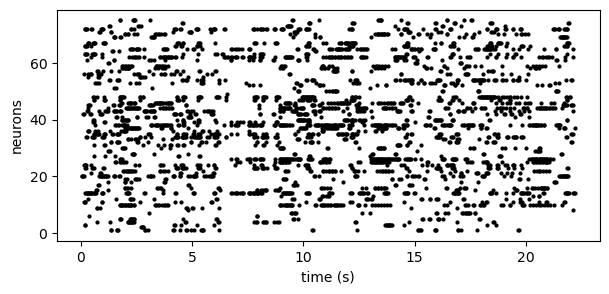

In [3]:
fig = seq.plot_raster(spikes; color="k") # returns matplotlib Figure
fig.set_size_inches([7, 3]);

## Specify PP-Seq model

In [4]:
config = Dict(

    # Model hyperparameters
    :num_sequence_types =>  2,
    :seq_type_conc_param => 1.0,
    :seq_event_rate => 1.0,

    :mean_event_amplitude => 100.0,
    :var_event_amplitude => 1000.0,
    
    :neuron_response_conc_param => 0.1,
    :neuron_offset_pseudo_obs => 1.0,
    :neuron_width_pseudo_obs => 1.0,
    :neuron_width_prior => 0.5,
    
    :num_warp_values => 1,
    :max_warp => 1.0,
    :warp_variance => 1.0,
    :warp_type => 1,

    :mean_bkgd_spike_rate => 30.0,
    :var_bkgd_spike_rate => 30.0,
    :bkgd_spikes_conc_param => 0.3,
    :max_sequence_length => Inf,
    
    # MCMC Sampling parameters.
    :num_threads => 2,  # <--- This is the key parameter to include if you want to run parallel MCMC
    :num_anneals => 10,
    :samples_per_anneal => 100,
    :max_temperature => 40.0,
    :save_every_during_anneal => 10,
    :samples_after_anneal => 2000,
    :save_every_after_anneal => 10,
    :split_merge_moves_during_anneal => 0,  # SPLIT / MERGE not implemented for distributed MCMC
    :split_merge_moves_after_anneal => 0,   # SPLIT / MERGE not implemented for distributed MCMC
    :split_merge_window => 1.0,
    
    # Masking parameters
    :are_we_masking => 0,
    
    # Sacred Sequence parameters
    :sacred_sequences => 0

);

## Train PPSeq model

In [5]:
# Initialize all spikes to background process.
init_assignments = fill(-1, length(spikes))

# Construct model struct (PPSeq instance).
model = seq.construct_model(config, max_time, num_neurons)

# Run Gibbs sampling with an initial annealing period.
results = seq.easy_sample!(model, spikes, init_assignments, config);

(warp_values, warp_log_proportions) = ([1.0], [0.0])
TEMP:  39.99999999999999
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  26.549315324802276
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  17.621653605394528
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  11.696070952851464
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  7.763066894712855
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  5.152602771881631
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  3.419951893353394
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  2.269934530307346
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.5066301902946675
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.0
10-20-30-40-50-60-70-80-90-100-Done
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-

## Plot results

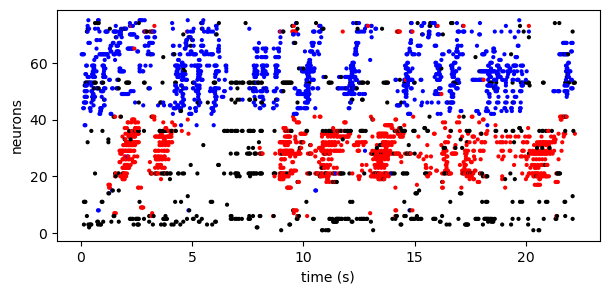

In [6]:
# Grab the final MCMC sample
final_globals = results[:globals_hist][end]
final_events = results[:latent_event_hist][end]
final_assignments = results[:assignment_hist][:, end]

# Helpful utility function that sorts the neurons to reveal sequences.
neuron_ordering = seq.sortperm_neurons(final_globals)

# Plot model-annotated raster.
fig = seq.plot_raster(
    spikes,
    final_events,
    final_assignments,
    neuron_ordering;
    color_cycle=["red", "blue"] # colors for each sequence type can be modified.
)
fig.set_size_inches([7, 3]);